# Agentes en LangGraph con Gemini


## Caso 6 Agente con memoria

<img src="https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png" alt="gate" width="600"/>

Muchos de las aplicaciones de agentes requieren tener memoria para que el agente pueda validar eventos, contexto o datos anteriormente suministrados en la conversación. Existen dos tipos de memoria: a corto plazo y largo plano.

### Memoria a corto plazo: 
usualmente se habla de un id de conversación. Si ha interactuado con uno o varios agente en una intención de forma reciente, es lo que se considera memoria a corto plazo

### Memoria a largo plazo: 
usualmente asociado al id del usurio, esta memoria es el historico de conversaciones o eventos que han pasado en multiples interacciones en una ventana de tiempo extenza por uno o varios agente de IA o humanos incluso cuando la memoria se mezcla con eventos en un CRM para canales de atención

En este ejemplo trabajaremos la memoria a corto plazo. Hay diferentes herramientas o formas de tener memoria a largo plazo, recomiendo usar herramientas como [Memory Bank](https://cloud.google.com/vertex-ai/generative-ai/docs/agent-engine/memory-bank/overview) de GCP.

In [1]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
#from typing_extensions import Literal

In [2]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Declaración y llamado de la key del modelo LLM
# use esta función para definir la key del modelo LLM si tuvo problemas con el archivo .env.json o create_env.py
def _set_env(var: str):
   if not os.environ.get(var):
       os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

Iniciamos definiendo algunas tools para nuestro agente

In [3]:
def multiply(a: int, b: int) -> int:
    """
    Multiplica dos números enteros y retorna el resultado.

    Esta función toma dos argumentos de tipo entero, 'a' y 'b', y retorna el producto de ambos.
    Es útil cuando se requiere realizar operaciones de multiplicación en flujos de trabajo matemáticos
    o como parte de herramientas de cálculo para agentes conversacionales.

    Args:
        a: Primer número entero a multiplicar.
        b: Segundo número entero a multiplicar.

    Returns:
        El resultado de multiplicar 'a' por 'b' como un entero.
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Suma dos números enteros y retorna el resultado.

    Esta función recibe dos argumentos de tipo entero, 'a' y 'b', y retorna la suma de ambos.
    Es útil para realizar operaciones aritméticas básicas, como sumar cantidades, totales o valores
    en diferentes contextos dentro de un agente conversacional.

    Args:
        a: Primer número entero a sumar.
        b: Segundo número entero a sumar.

    Returns:
        La suma de 'a' y 'b' como un entero.
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide el primer número entero por el segundo y retorna el resultado como flotante.

    Esta función toma dos argumentos de tipo entero, 'a' y 'b', y retorna el cociente de la división de 'a' entre 'b'.
    Es importante asegurarse de que 'b' no sea cero para evitar errores de división.
    Es útil para calcular proporciones, promedios u otras operaciones que requieran división en agentes conversacionales.

    Args:
        a: Número entero que será el dividendo.
        b: Número entero que será el divisor (no debe ser cero).

    Returns:
        El resultado de dividir 'a' entre 'b' como un número flotante.
    """
    return a / b


Definimos estas funciones como tools para nuestro agente

In [4]:
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

Ahora definimos la entrada del mensaje que nos dará el usurio y el nodo que usaremos

In [5]:
# Esta línea crea un mensaje de sistema (SystemMessage) que se utiliza para establecer el comportamiento y las instrucciones iniciales del asistente conversacional.
# El contenido del mensaje indica que el asistente debe ser útil y está encargado de realizar operaciones aritméticas sobre un conjunto de entradas.
# Este mensaje se envía al modelo de lenguaje como contexto para guiar sus respuestas y asegurar que actúe de acuerdo a la tarea especificada.
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Nodo
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Inicializamos el grafo

In [6]:
builder = StateGraph(MessagesState)


Ahora agregamos los nodos, que serán `assistant` y las Tools que definimos incialmente

In [7]:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

Ahora definimos las aristas de nuestro grafo

In [8]:
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # Si el último mensaje (resultado) del asistente es una llamada a una herramienta -> tools_condition dirige a tools
    # Si el último mensaje (resultado) del asistente NO es una llamada a una herramienta -> tools_condition dirige a END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

Compilamos el grafo

In [9]:
react_graph = builder.compile()

Ahora podemos visualizar el grafo que hemos 

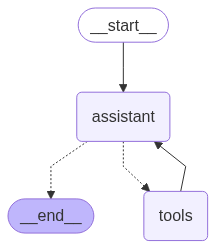

In [10]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Ahora vamos a probar el agente

In [11]:
messages = [HumanMessage(content="Suma 3 y 4.")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:  
    # Imprime el mensaje de una forma más legible
    # pretty_print() es una función que se utiliza para imprimir el mensaje de una forma más legible.
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (5363731c-6429-4c9e-904a-fa786ef18602)
 Call ID: 5363731c-6429-4c9e-904a-fa786ef18602
  Args:
    b: 4.0
    a: 3.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


Podemos validar que está usando las tools solicitando diferntes operaciones

In [12]:
messages = [HumanMessage(content="Multiplica eso por si mismo.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiplica eso por si mismo.
================================== Ai Message ==================================

Por favor, proporciona un número para multiplicar por sí mismo.


**¡No conservamos la memoria del 7 de nuestro chat inicial!**

Esto ocurre porque el estado es transitorio y solo dura durante la ejecución de un único grafo. Por lo tanto, esto limita nuestra capacidad para mantener conversaciones de varios turnos o con interrupciones. Podemos resolver este problema utilizando persistencia.

LangGraph permite usar un `checkpointer` para guardar automáticamente el estado del grafo después de cada paso.

Esta capa de persistencia incorporada nos da memoria, permitiendo que LangGraph retome desde la última actualización de estado.

Uno de los checkpointers más sencillos de usar es `MemorySaver`, que es un almacén clave-valor en memoria para el estado del grafo. Solo necesitamos compilar el grafo con un checkpointer, ¡y así nuestro grafo tendrá memoria!

In [13]:
from langgraph.checkpoint.memory import MemorySaver  # Importamos MemorySaver para guardar el estado en memoria
memory = MemorySaver()  # Creamos una instancia de MemorySaver (almacén en memoria para el estado del grafo)
react_graph_memory = builder.compile(checkpointer=memory)  # Compilamos el grafo usando el checkpointer para habilitar la persistencia (memoria)

### Representación del Flujo en LangGraph

```mermaid
graph TD
    A[Estado inicial: {state: "I"}] --> N1[🔴 Nodo 1]
    N1 --> N2[🔵 Nodo 2]
    N2 --> B[Estado final: {state: "I heart langgraph"}]
```

---

### 🔹 Conceptos Clave

| Componente     | Descripción                                                                 |
|----------------|-----------------------------------------------------------------------------|
| **Grafo**      | Flujo de control entre nodos y aristas.                                    |
| **Super-pasos**| Cada nodo secuencial representa un super-paso. Nodos paralelos comparten el mismo super-paso. |
| **Checkpoints**| En cada super-paso se guarda el estado y metadatos relevantes.             |
| **Thread (Hilo)**  | Colección de checkpoints que representan una ejecución del grafo.       |

---

### Ejemplo de Checkpoints para diferentes aplicaciones

#### 🔴 Checkpoint del Nodo 1
```json
{
  "state": "I heart",
  "next": "nodo 2",
  "id": "...",
  "otros": "..."
}
```

#### 🔵 Checkpoint del Nodo 2
```json
{
  "state": "I heart langgraph",
  "next": "end",
  "id": "...",
  "otros": "..."
}
```

---

###  Hilo (Thread)

Una **colección de checkpoints** ordenados que representan una ejecución completa del grafo. Sirve como historial y permite la recuperación o análisis de cada paso.

---



Ahora vamos a definir un Thread y hacer de nuevo otros llamados usando la memoria

In [14]:
# Definir la configuración para el hilo específico donde se almacenará el historial de la conversación.
config = {"configurable": {"thread_id": "1"}}

# Crear el mensaje de entrada que el usuario envía al agente.
messages = [HumanMessage(content="Suma 3 y 4.")]

# Ejecutar el grafo de razonamiento con memoria, pasando los mensajes y la configuración del hilo.
messages = react_graph_memory.invoke({"messages": messages}, config)

# Recorrer todos los mensajes resultantes y mostrarlos de forma legible.
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (eae4c54d-fa09-44ab-b3cc-35f45f807c64)
 Call ID: eae4c54d-fa09-44ab-b3cc-35f45f807c64
  Args:
    b: 4.0
    a: 3.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


Si utilizamos el mismo `thread_id`, el agente puede continuar desde el último estado guardado en el historial (`checkpoint`) de la conversación.

Es decir, toda la conversación previa (por ejemplo, la suma de 3 y 4) queda registrada en el hilo identificado por ese `thread_id`.

Cuando enviamos un nuevo mensaje del usuario, como `Multiplica eso por 2.`, este mensaje se añade al historial de la conversación en ese mismo hilo.

De esta manera, el modelo tiene acceso al contexto completo: sabe que "eso" se refiere al resultado anterior ("La suma de 3 y 4 es 7"), y puede realizar la nueva operación correctamente (multiplicar 7 por 2).

Así, la memoria del hilo permite que el agente entienda referencias a mensajes previos y mantenga coherencia en la conversación.

In [15]:
messages = [HumanMessage(content="Multiplica eso por 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Suma 3 y 4.
================================== Ai Message ==================================
Tool Calls:
  add (eae4c54d-fa09-44ab-b3cc-35f45f807c64)
 Call ID: eae4c54d-fa09-44ab-b3cc-35f45f807c64
  Args:
    b: 4.0
    a: 3.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7
================================ Human Message =================================

Multiplica eso por 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (3b8ce371-5c10-4713-a883-77a673cf74e6)
 Call ID: 3b8ce371-5c10-4713-a883-77a673cf74e6
  Args:
    b: 2.0
    a: 7.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

14


# LangGraph Studio

### AVISO IMPORTANTE

LangGraph Studio ha sido actualizado para que puedas ejecutarlo localmente en tu propia máquina y abrirlo directamente en tu navegador web. Esta es ahora la forma recomendada de utilizar Studio, en lugar de la aplicación de escritorio

¿Qué significa esto?

- Ya no necesitas instalar una aplicación de escritorio separada.
- Puedes iniciar el servidor de desarrollo localmente, lo que te permite trabajar de manera más flexible y rápida.
- El entorno de Studio se abrirá en tu navegador, facilitando la interacción y el desarrollo.

¿Cómo lo hago?

1. Abre una terminal y navega a la carpeta donde haya desarrolado el agente, ejemplo `Ejemplos\Agente expuesto en un API `.
2. Ejecuta el siguiente comando para iniciar el servidor de desarrollo local de LangGraph Studio:

  ```
  langgraph dev
  ```

3. Una vez iniciado, abre tu navegador y accede a la dirección local que se mostrará en la terminal (por lo general, `http://localhost:8000` o similar).

Para más detalles y documentación sobre cómo utilizar el servidor de desarrollo local y las nuevas funcionalidades de Studio, consulta la documentación oficial de LangGraph Studio.

De esta manera, podrás experimentar y desarrollar tus flujos de trabajo de manera más eficiente y cómoda directamente desde tu navegador.

# Agente expuesto como servicio de API

Para finalizar este tutorial báscio, recomedamos leer `Ejemplos\Agente expuesto en un API ` donde se expone una forma de como desplegar un agente con memoria y diferetentes tools por medio de un API. Remitase al `Ejemplos\Agente expuesto en un API\README.md` y siga las instrucciones para ejecutar el agente.